# GODAS
https://catalog.pangeo.io/browse/master/ocean/GODAS/

https://www.psl.noaa.gov//data/gridded/data.godas.html

In [7]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [8]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7668b6ae941f4450a1a80be6f4c8e4a8 Dashboard: /services/dask-gateway/clusters/prod.7668b6ae941f4450a1a80be6f4c8e4a8/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline

In [3]:
xr.set_options(display_style='text')

In [10]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
ds = xr.open_zarr(mapping, consolidated=True)

In [35]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [37]:
coords

<xarray.Dataset>
Dimensions:  (lat: 417, lat_u: 417, level: 40, level_w: 40, lon: 360, lon_u: 360, time: 471)
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.5 63.83 64.17 64.5
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w  (level_w) float32 10.0 20.0 30.0 ... 3.727e+03 4.225e+03 4.736e+03
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lon_u    (lon_u) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
Data variables:
    *empty*
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

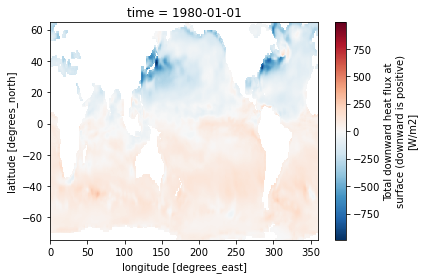

In [44]:
ds.thflx[0].plot()

In [56]:
coords_roll = coords.roll(lon=500, lon_u=500)
ds_roll = ds.roll(lon=500, lon_u=500)

<ipython-input-56-ed45c25d685c>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_roll = coords.roll(lon=500, lon_u=500)
<ipython-input-56-ed45c25d685c>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll = ds.roll(lon=500, lon_u=500)


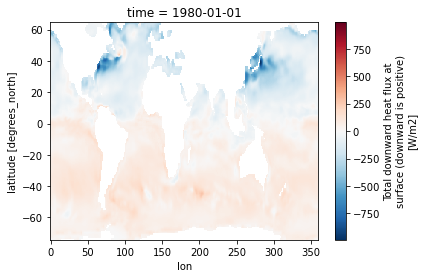

In [57]:
ds_roll.thflx[0].drop('lon').plot()

In [69]:
ds_roll.lon.isel(lon=170)

<xarray.DataArray 'lon' ()>
array(30.5, dtype=float32)
Coordinates:
    lon      float32 30.5
Attributes:
    GridType:       Cylindrical Equidistant Projection Grid
    actual_range:   [0.5, 359.5]
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [7]:
ds.attrs

{'Conventions': 'COARDS',
 'References': 'https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html',
 'comment': 'NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.',
 'creation_date': 'Sat Dec 16 20:00:00 MDT 2006',
 'dataset_title': 'NCEP Global Ocean Data Assimilation System (GODAS)',
 'grib_file': 'godas.M.198001-12.grb',
 'history': 'Created 2006/12 by Hoop',
 'html_BACKGROUND': 'http://www.cpc.ncep.noaa.gov/products/GODAS/background.shtml',
 'html_GODAS': 'www.cpc.ncep.noaa.gov/products/GODAS',
 'html_REFERENCES': 'http://www.cpc.ncep.noaa.gov/products/GODAS/background.shtml',
 'sfcHeatFlux': '\nNote that the net surface heat flux are the total surface heat flux \nfrom the NCEP reanalysis 2 plus the relaxation terms.',
 'time_comment': 'The internal time stamp indicates the FIRST day of the averaging period.',
 'title': 'GODAS: Global Ocean Data Assimilation System'}

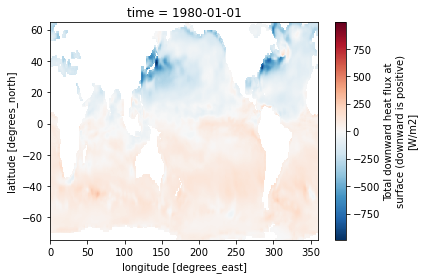

In [9]:
ds.thflx[0].plot()

In [70]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
#WG model's boundaries after .roll(XC=700) (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-74.16667
upper_lat = 37 #-61.83
left_lon =  70 #290.5
right_lon = 170 #30.5

In [73]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

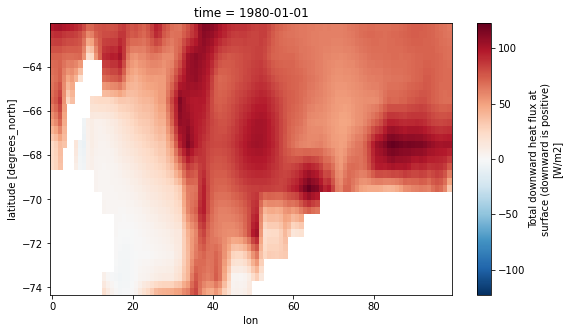

In [77]:
ds_roll.thflx[0].isel(**lat_range, **lon_range).drop('lon').plot(figsize=(9,5))